### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy.stats import norm
import math

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
for i in cohort_studies:
    cohort_studies[i]['Age']=cohort_studies_sub[i]['Age']

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [15]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [16]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [17]:
# atn

In [18]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [19]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# diag

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [21]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [22]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [23]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [24]:
cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR'}, inplace=True)

# Plot the CSF biomarkers in different cohorts

In [25]:
# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in atn.index:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma, colo in zip(csf, colors):
# #         print(bioma, csf.index(bioma))
#         sns.histplot(cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
# #         axes[i, csf.index(bioma)].set_title(bioma.upper())
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
#     i+=1
    
# # plt.savefig("csf_biomarkers.png", dpi=300)

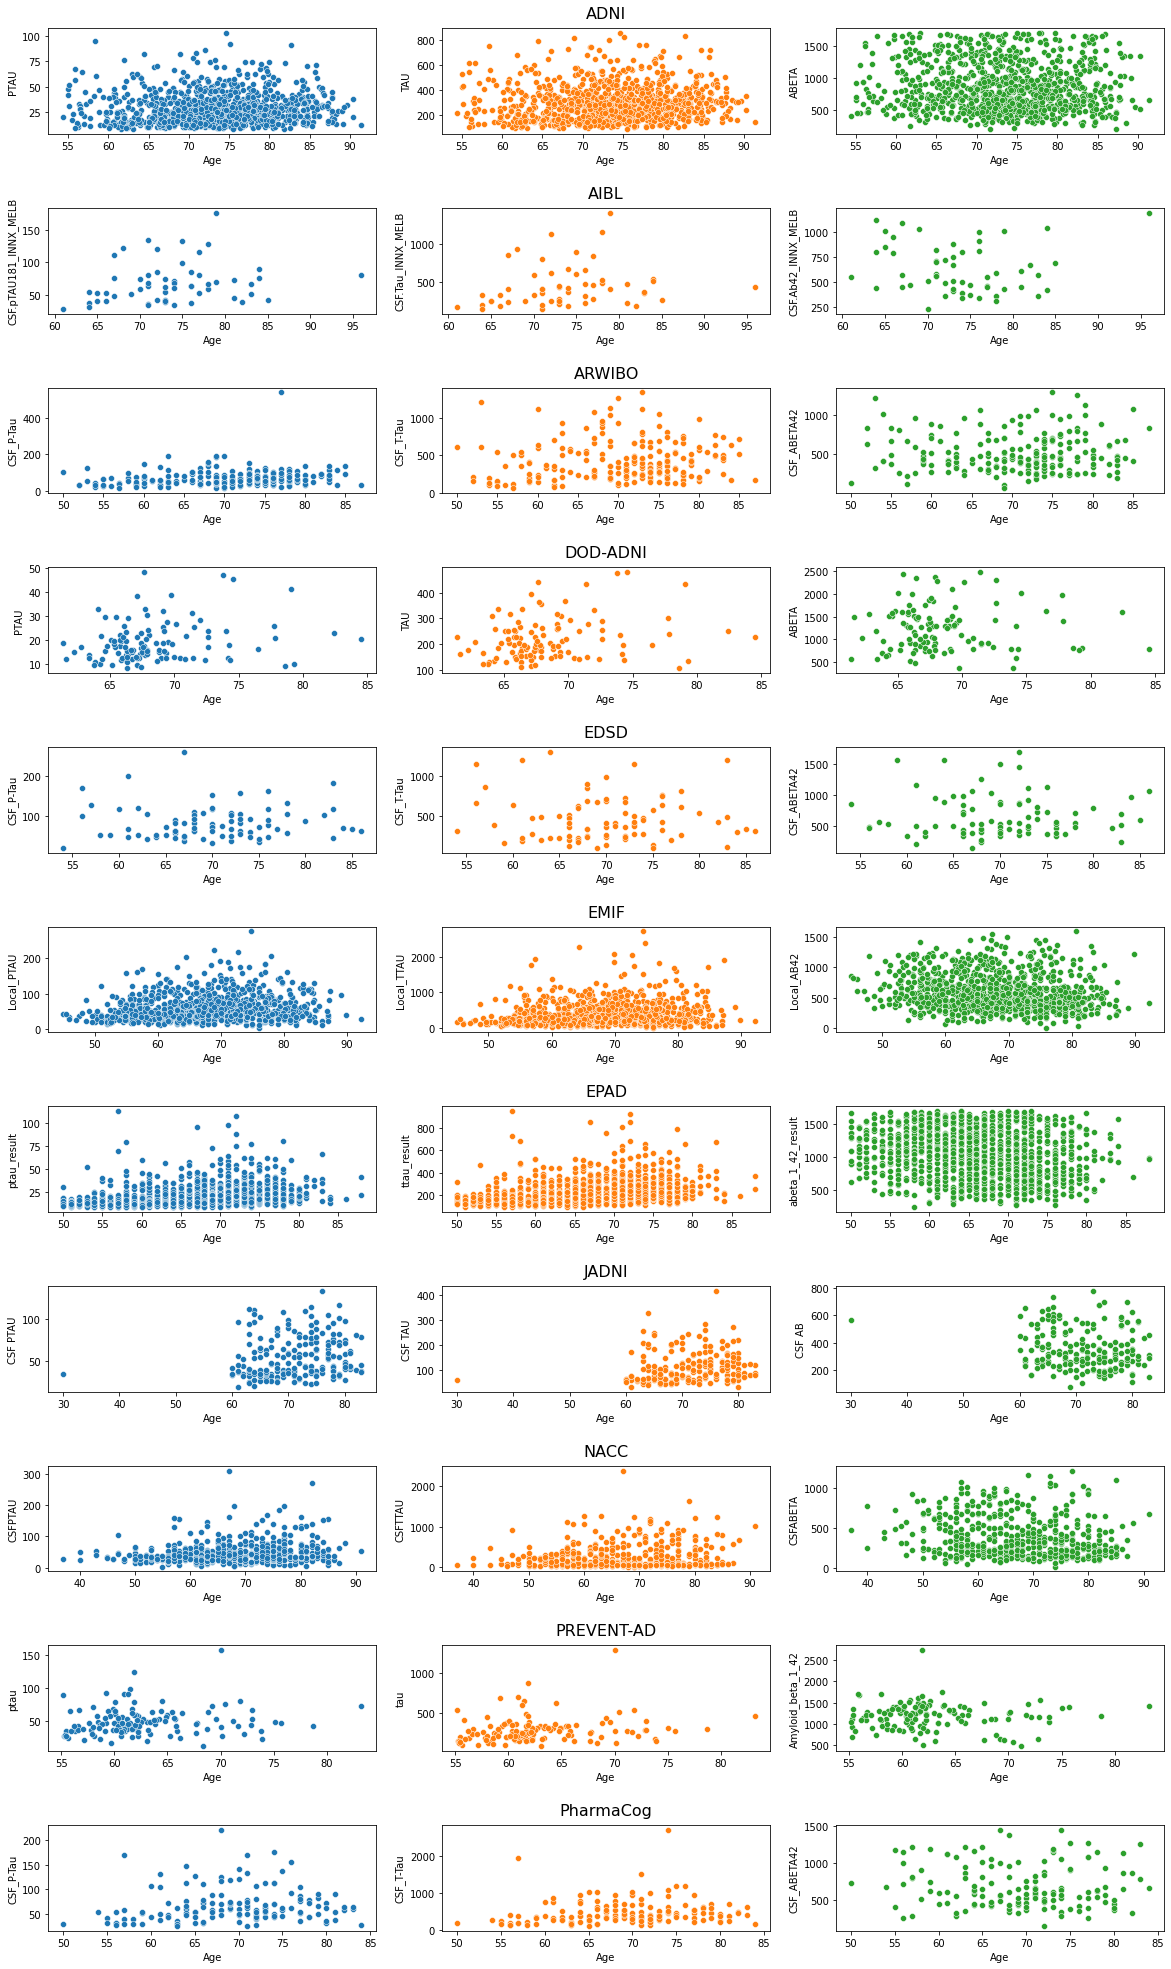

In [26]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in atn.index:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, colo in zip(csf, colors):
#         print(bioma, csf.index(bioma))
        sns.scatterplot(x=cohort_studies[ind]['Age'], y=cohort_studies[ind][bioma].dropna(), ax=axes[i, csf.index(bioma)], color=colo)
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1
    
# plt.savefig("csf_biomarkers.png", dpi=300)

### Clustering CSF biomarkers, two classes, normal vs abnormal

### subset each cohort dataset based on the columns of interest for clustering 

In [27]:
cohorts_csf = dict()

for i in atn.index:
    csf = mappings['csf'].iloc[:3][i].to_list()
    cohorts_csf[i] = cohort_studies[i][csf + ["Diagnosis", "Age"]]
    cohorts_csf[i] = cohorts_csf[i].dropna(subset=cohorts_csf[i].columns[:3].to_list() + ['Age']) # drop empty rows (CSF biomarkers)
#     for col in ['A', 'T', 'N']:
#         cohorts_csf[i][col]=np.nan

# Gaussian Mixture Model (GMM)

### Scale CSF Features

In [28]:
# scale each feature and write it as a new column in the respective dataframe
# name the new columns with a suffix "_scaled"
for cohort in cohorts_csf:
    
    for i in cohorts_csf[cohort][cohorts_csf[cohort].columns[:3].to_list() + ['Age']]: 
        cohorts_csf[cohort][i + '_scaled'] = MinMaxScaler().fit_transform(X=cohorts_csf[cohort][[i]])

In [29]:
for i in cohorts_csf:
    if len(cohorts_csf[i][cohorts_csf[i].columns[1]]) != len(cohorts_csf[i]['Age_scaled'].dropna()):
        print(i)

### GMM Training

In [30]:
hypersss = dict()
scoresss = dict()
silhouette = dict()

for i in cohorts_csf:
    
    # Create empty dictionary for storing hyperparameters (number of clusters)
    hyper = dict()

    # Create empty dictionary for storing BIC scores
    scores = dict()
    
    # Create empty dictionary for storing silhouette scores
    sil_scores = dict()

    # Define different number of clusters to explore
    n_clus = range(2, 5, 1) 

    for biom in [x + "_scaled" for x in mappings['csf'].iloc[:3][i].to_list()]:

        clus = list()
        bic_ = list()
        sil = list()

        for n in n_clus:

            # Set the model and its parameter
            model = GaussianMixture(n_components=n, n_init=20)
            # Fit the model 
            clm = model.fit(cohorts_csf[i][biom].values.reshape(-1,1))
            lables = clm.predict(cohorts_csf[i][biom].values.reshape(-1,1))
            
            # Calculate BIC Scores and silhouette scores then store them in a dictionaries
            clus.append(n)
            bic_.append(clm.bic(cohorts_csf[i][biom].values.reshape(-1,1))) # BIC scores
            sil.append(metrics.silhouette_score(cohorts_csf[i][biom].values.reshape(-1,1), lables))
            
        hyper[biom] = clus
        scores[biom] = bic_
        sil_scores[biom] = sil
        
    hypersss[i] = hyper
    scoresss[i] = scores
    silhouette[i] = sil_scores

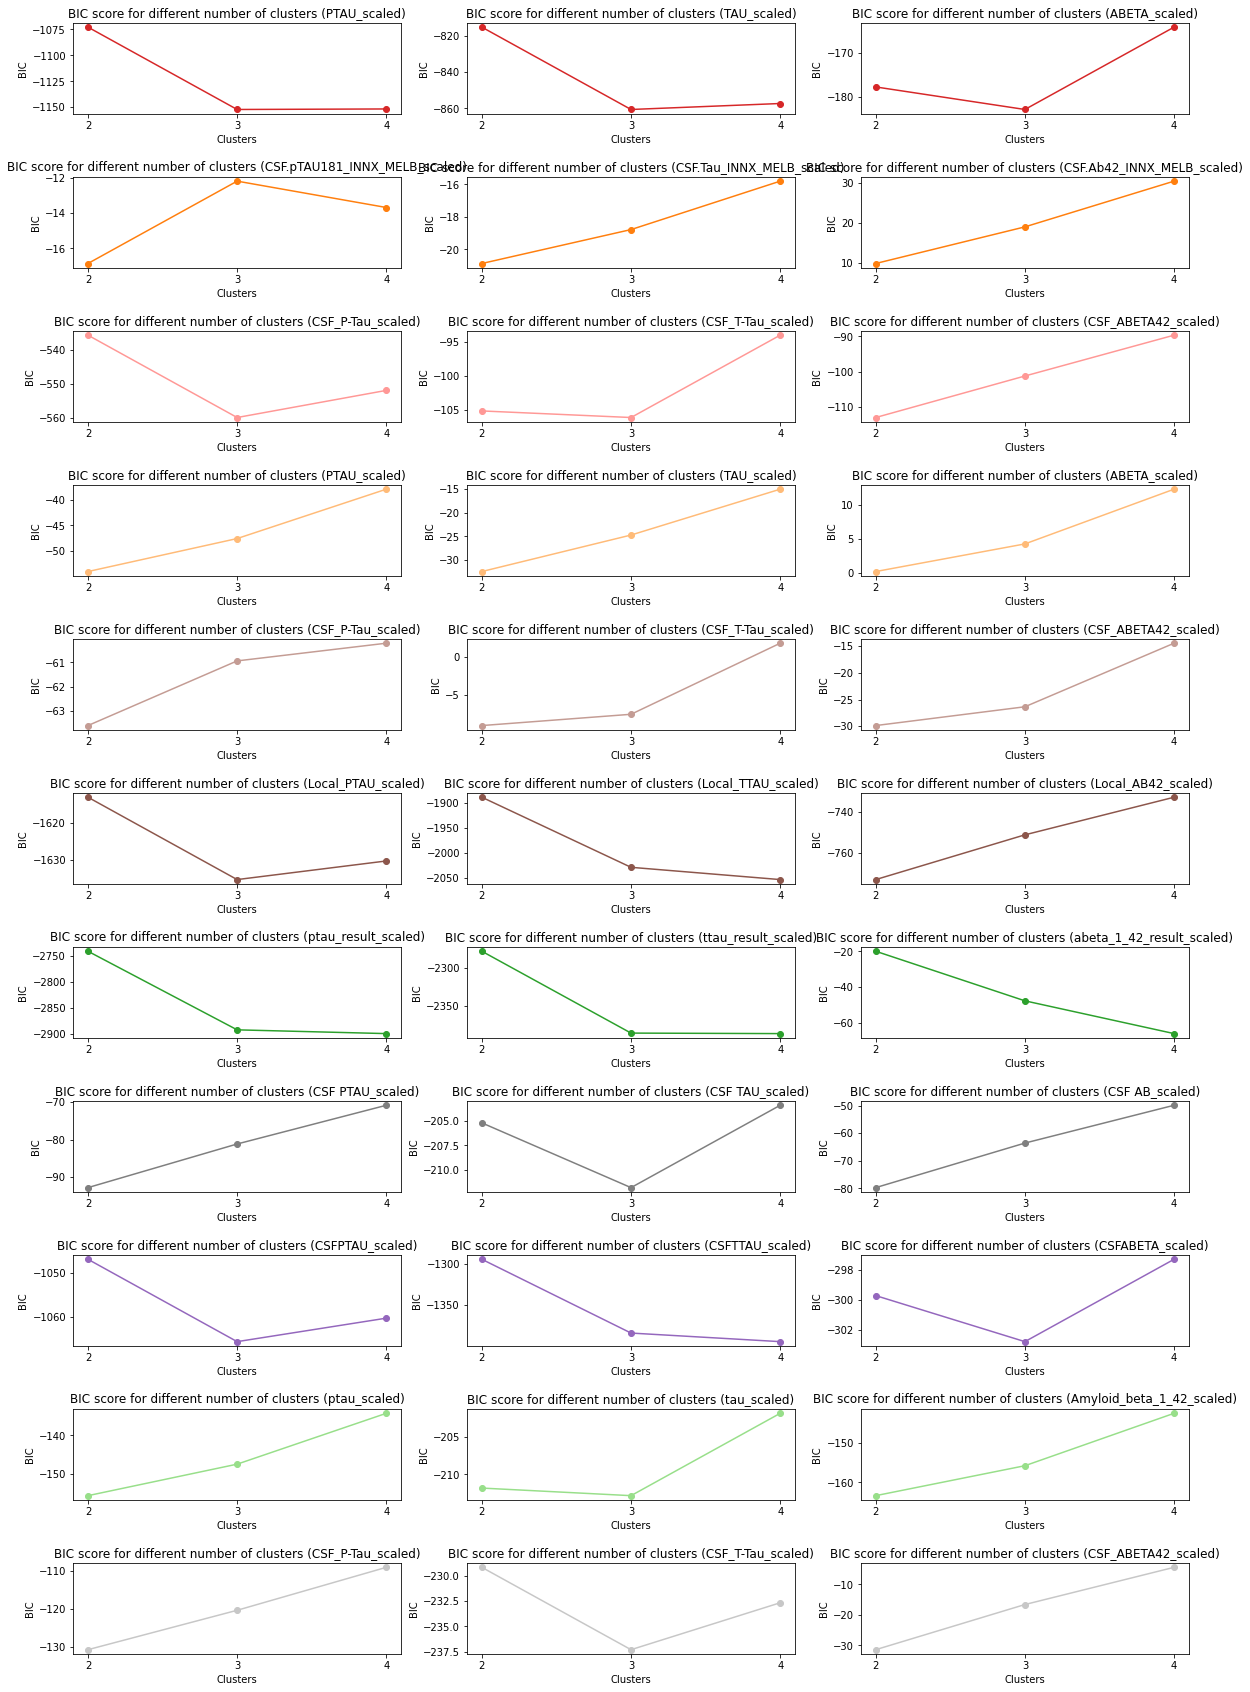

In [31]:
colors = {'ADNI': '#d62728', 'ANM': '#1f77b4', 'AIBL': '#ff7f0e', 'EPAD': '#2ca02c', 
          'NACC': '#9467bd', 'EMIF': '#8c564b', 'ROSMAP': '#e377c2', 'JADNI': '#7f7f7f', 
          'A4': '#aec7e8', 'DOD-ADNI': '#ffbb78', 'PREVENT-AD': '#98df8a', 'ARWIBO': '#ff9896', 
          'I-ADNI': '#c5b0d5', 'EDSD': '#c49c94', 'OASIS': '#f7b6d2', 'PharmaCog': '#c7c7c7', 
          'VITA': '#bcbd22', 'WMH-AD': '#dbdb8d', 'VASCULAR': '#9edae5', 'ABVIB': '#e0d9e2'}

fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], scoresss[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Clusters')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('BIC')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'BIC score for different number of clusters ({i})')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xticks(hypersss[cohort][i])
    ind+=1

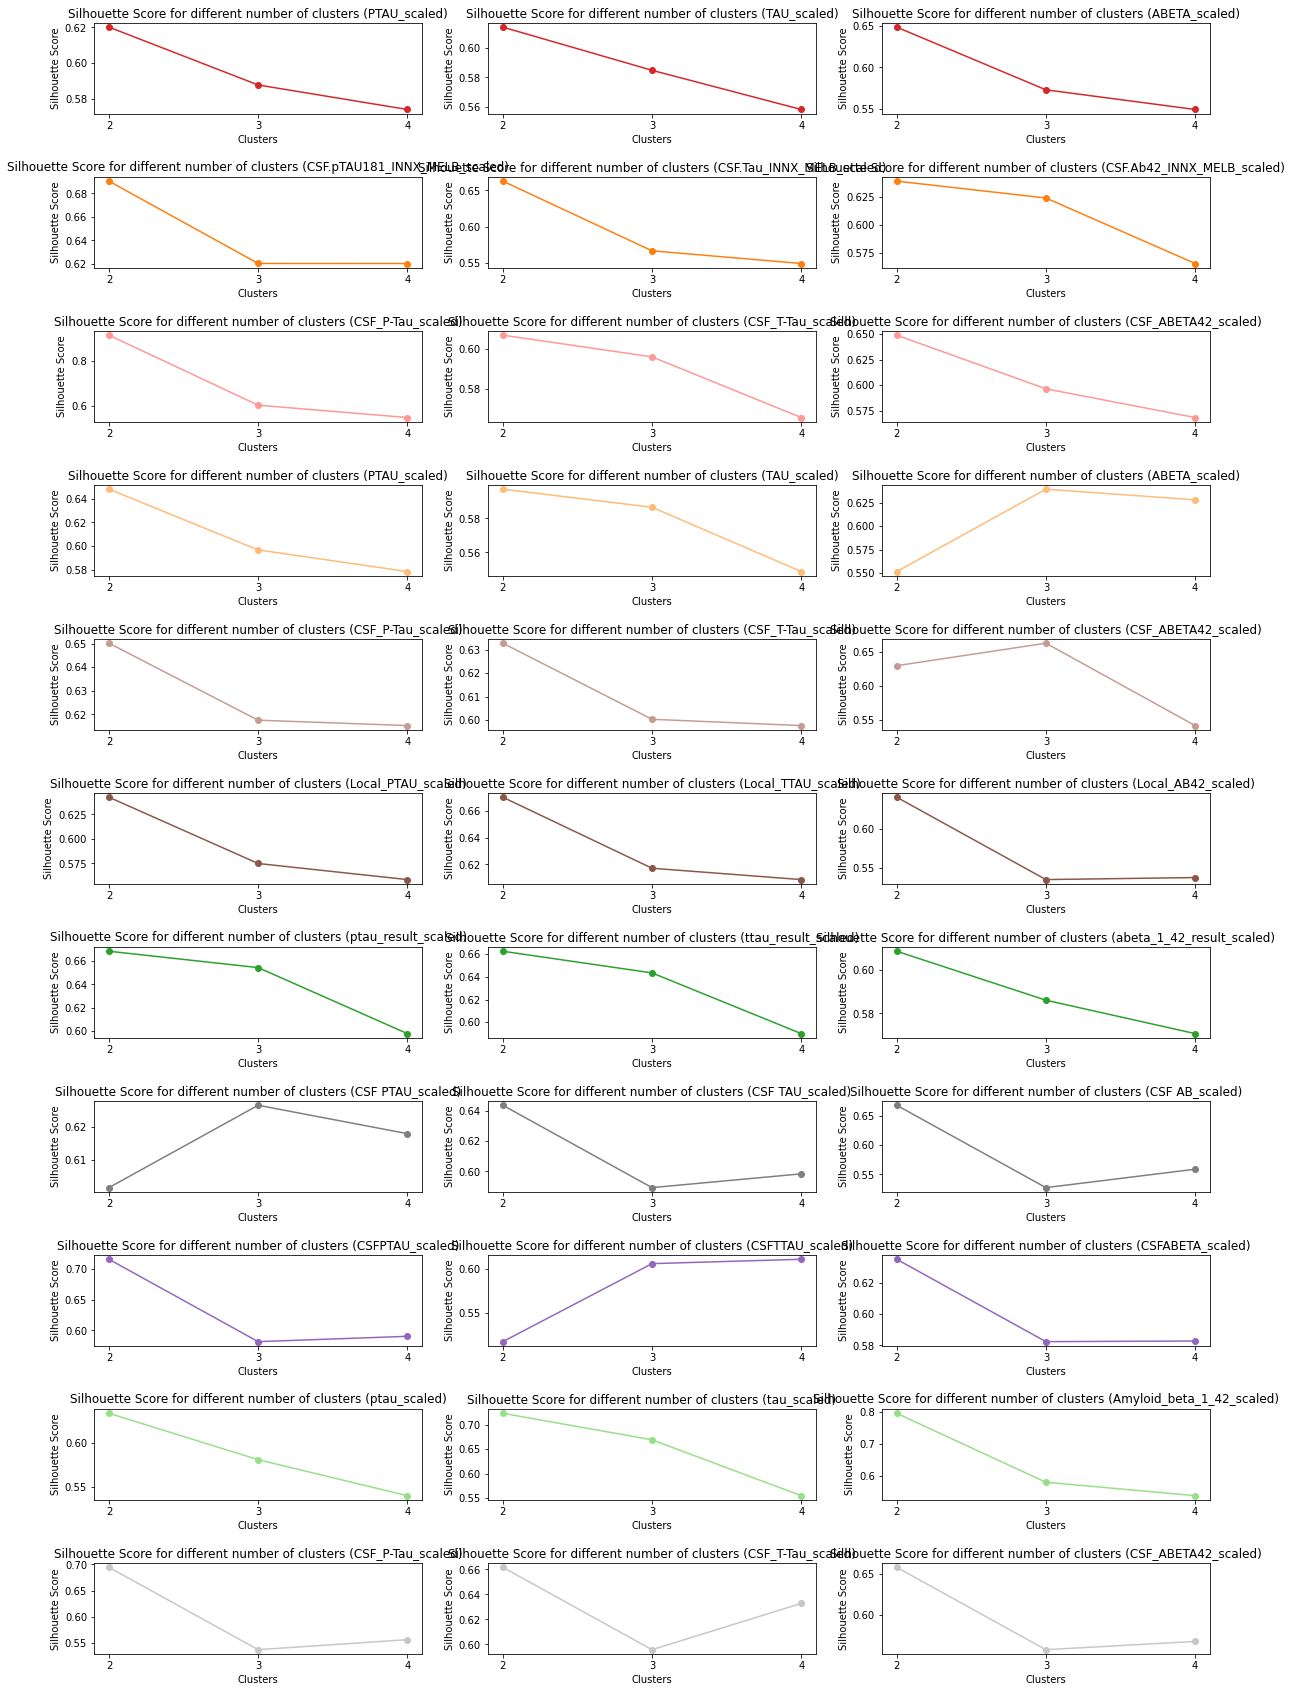

In [32]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 30))
fig.subplots_adjust(hspace=0.7)
ind=0

for cohort in hypersss:
    
    for i in hypersss[cohort]:
        # Plot the resulting BIC scores on a graph
        axes[ind, list(hypersss[cohort].keys()).index(i)].plot(hypersss[cohort][i], silhouette[cohort][i], 'o-', color=colors[cohort])
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xlabel('Clusters')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_ylabel('Silhouette Score')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_title(f'Silhouette Score for different number of clusters ({i})')
        axes[ind, list(hypersss[cohort].keys()).index(i)].set_xticks(hypersss[cohort][i])
    ind+=1

### Save all BIC scores and number of clusters into dataframes for each cohort

In [33]:
score_hyper_dfs = dict()

for i in scoresss:
    for bio in scoresss[i]:
        score_df = pd.DataFrame.from_dict(scoresss[i], orient='index').transpose()
        score_df.columns = [x + '_score' for x in  score_df.columns]
        hyper_df = pd.DataFrame.from_dict(hypersss[i], orient='index').transpose()
        hyper_df.columns = [x + '_hyper' for x in  hyper_df.columns]
        score_hyper_dfs[i] = pd.concat([score_df, hyper_df], axis=1)

In [34]:
[col.split('_')[0] for col in score_hyper_dfs['ADNI'].columns[:3]]

['PTAU', 'TAU', 'ABETA']

In [35]:
my_cols = list()

for prefix in ['mean1_', 'mean2_', 'var1_', 'var2_']:
    
    for i in mappings['csf']['Feature'][:3].to_list():
        my_cols.append(prefix + i)
        
# make an empty df to save the mean and covariances        
mean_variances_df = pd.DataFrame(index=cohorts_csf.keys(), columns=my_cols)

In [36]:
score_hyper_dfs['ADNI']

,PTAU_scaled_score,TAU_scaled_score,ABETA_scaled_score,PTAU_scaled_hyper,TAU_scaled_hyper,ABETA_scaled_hyper
0,-1072.789011,-815.375584,-177.690987,2,2,2
1,-1152.135115,-860.626693,-182.807892,3,3,3
2,-1151.633800,-857.344553,-164.116412,4,4,4


In [37]:
for cname in score_hyper_dfs:
    
    for col in score_hyper_dfs[cname].columns:

        if '_score' in col:
            hypers_ = col.split('_score')[0] + '_hyper' 
            n_clus = score_hyper_dfs[cname].loc[score_hyper_dfs[cname][col] == np.min(score_hyper_dfs[cname][col]), hypers_].iloc[0]
            variable = mappings['csf'].loc[mappings['csf'][cname]==col.split('_scaled_score')[0], 'Feature'].item()
            
            # Set the model and its parameters
#             model = GaussianMixture(n_components=n_clus)
            model = GaussianMixture(n_components=2, n_init=20)

            # Fit the model 
            clm = model.fit(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
            # extract the mean and std of each Gaussian
            mean_variances_df.loc[cname, 'mean1_' + variable] = clm.means_.tolist()[0][0]
            mean_variances_df.loc[cname, 'mean2_' + variable] = clm.means_.tolist()[1][0]
            # note: we can extract the covariance matrix where the diagonal elements are variance
            # square root of variance will result in std
            mean_variances_df.loc[cname, 'var1_' + variable] = math.sqrt(clm.covariances_.tolist()[0][0][0])
            mean_variances_df.loc[cname, 'var2_' + variable] = math.sqrt(clm.covariances_.tolist()[1][0][0])
            
            cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN"] = clm.predict(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))
            prob0 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,0]
            prob1 = clm.predict_proba(cohorts_csf[cname][col.split('_score')[0]].values.reshape(-1,1))[:,1]
            cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_0"], cohorts_csf[cname][str(col.split('_scaled_score')[0]) + "_ATN_probab_1"] = prob0, prob1

In [38]:
mean_variances_df

,mean1_pTau in CSF,mean1_tTau in CSF,mean1_A-beta 1-42 in CSF,mean2_pTau in CSF,mean2_tTau in CSF,mean2_A-beta 1-42 in CSF,var1_pTau in CSF,var1_tTau in CSF,var1_A-beta 1-42 in CSF,var2_pTau in CSF,var2_tTau in CSF,var2_A-beta 1-42 in CSF
ADNI,0.37849,0.177373,0.298433,0.138055,0.439836,0.736308,0.165413,0.093326,0.127506,0.082237,0.179817,0.157726
AIBL,0.194283,0.522139,0.236409,0.64803,0.142935,0.64704,0.11368,0.224453,0.103823,0.155927,0.095449,0.182391
ARWIBO,0.105473,0.460102,0.25391,1.0,0.170824,0.568566,0.065701,0.194767,0.093595,0.001,0.091945,0.165398
DOD-ADNI,0.185212,0.199209,0.201298,0.524515,0.509361,0.52658,0.10274,0.108658,0.080551,0.22351,0.226723,0.20744
EDSD,0.208895,0.175055,0.194641,0.489331,0.525016,0.495325,0.102394,0.107029,0.072445,0.212705,0.224173,0.215186
EMIF,0.155854,0.288704,0.282878,0.351251,0.093268,0.598675,0.066609,0.156072,0.100164,0.144154,0.055614,0.144488
EPAD,0.065685,0.282123,0.356519,0.232044,0.095705,0.758653,0.036563,0.151619,0.152846,0.141923,0.046955,0.140017
JADNI,0.143657,0.130412,0.286689,0.453375,0.379953,0.675152,0.05817,0.072864,0.108595,0.186786,0.164769,0.126927
NACC,0.333267,0.022392,0.172983,0.112861,0.175245,0.507764,0.165851,0.011955,0.076606,0.054953,0.134407,0.183545
PREVENT-AD,0.409637,0.411156,1.0,0.216381,0.139776,0.308608,0.195102,0.209376,0.001,0.087208,0.071028,0.118876


In [39]:
def reverse_standardization(dfs, cccs, csf_mappings):
    """
    dfs: a dictionary of dataframes where each df containes all CSF measurements, scaled CSF, etc. 
    cccs: df containing each cluster mean and SD for all CSF biomarkers
    csf_mappings: harmonized mapping of CSF biomarkers among the investigated cohorts
    """
    
    for study in dfs:
        
        for biomarker in csf_mappings['csf'].iloc[:3][study].to_list():
    
            min_, max_ = np.min(dfs[study][biomarker]), np.max(dfs[study][biomarker])
            featu = csf_mappings['csf'].loc[csf_mappings['csf'][study]==biomarker, 'Feature'].item()
            
            for prefix in ['mean1_', 'mean2_', 'var1_', 'var2_']:
#                 print(cccs.loc[study][prefix + featu])
                cccs.loc[study, prefix + featu + "_rs"]= round(cccs.loc[study][prefix + featu] * (max_ - min_) + min_, 2)
            
    return cccs

In [40]:
reverse_standardization(cohorts_csf, mean_variances_df, mappings)

,mean1_pTau in CSF,mean1_tTau in CSF,mean1_A-beta 1-42 in CSF,mean2_pTau in CSF,mean2_tTau in CSF,mean2_A-beta 1-42 in CSF,var1_pTau in CSF,var1_tTau in CSF,var1_A-beta 1-42 in CSF,var2_pTau in CSF,...,var1_pTau in CSF_rs,var2_pTau in CSF_rs,mean1_tTau in CSF_rs,mean2_tTau in CSF_rs,var1_tTau in CSF_rs,var2_tTau in CSF_rs,mean1_A-beta 1-42 in CSF_rs,mean2_A-beta 1-42 in CSF_rs,var1_A-beta 1-42 in CSF_rs,var2_A-beta 1-42 in CSF_rs
ADNI,0.37849,0.177373,0.298433,0.138055,0.439836,0.736308,0.165413,0.093326,0.127506,0.082237,...,23.89,16.01,224.05,424.33,159.91,225.91,648.86,1303.04,393.49,438.64
AIBL,0.194283,0.522139,0.236409,0.64803,0.142935,0.64704,0.11368,0.224453,0.103823,0.155927,...,45.72,51.93,807.47,318.73,423.80,257.53,458.26,856.49,329.69,405.88
ARWIBO,0.105473,0.460102,0.25391,1.0,0.170824,0.568566,0.065701,0.194767,0.093595,0.001,...,48.98,15.13,646.71,279.42,309.82,179.27,375.85,761.21,179.51,267.45
DOD-ADNI,0.185212,0.199209,0.201298,0.524515,0.509361,0.52658,0.10274,0.108658,0.080551,0.22351,...,12.34,17.21,180.70,297.01,146.75,191.02,791.93,1476.98,537.64,804.87
EDSD,0.208895,0.175055,0.194641,0.489331,0.525016,0.495325,0.102394,0.107029,0.072445,0.212705,...,44.57,71.05,310.07,730.02,228.44,369.01,443.42,913.69,252.30,475.55
EMIF,0.155854,0.288704,0.282878,0.351251,0.093268,0.598675,0.066609,0.156072,0.100164,0.144154,...,23.03,43.80,789.07,257.97,428.64,155.65,455.44,952.42,167.90,237.65
EPAD,0.065685,0.282123,0.356519,0.232044,0.095705,0.758653,0.036563,0.151619,0.152846,0.141923,...,11.83,22.87,336.15,177.34,224.97,135.81,761.48,1348.00,464.43,445.71
JADNI,0.143657,0.130412,0.286689,0.453375,0.379953,0.675152,0.05817,0.072864,0.108595,0.186786,...,26.05,40.83,84.18,179.65,62.17,97.33,277.06,549.43,152.19,165.05
NACC,0.333267,0.022392,0.172983,0.112861,0.175245,0.507764,0.165851,0.011955,0.076606,0.054953,...,54.54,20.41,59.73,424.45,34.83,327.01,222.69,625.59,106.69,235.40
PREVENT-AD,0.409637,0.411156,1.0,0.216381,0.139776,0.308608,0.195102,0.209376,0.001,0.087208,...,40.34,24.72,573.06,247.31,330.85,164.79,2728.00,1173.20,481.45,746.53


In [41]:
mean_sd_df = mean_variances_df[[col for col in mean_variances_df.columns if '_rs' in col]]

### plot all probabilistic clusters for each biomarker in each cohort

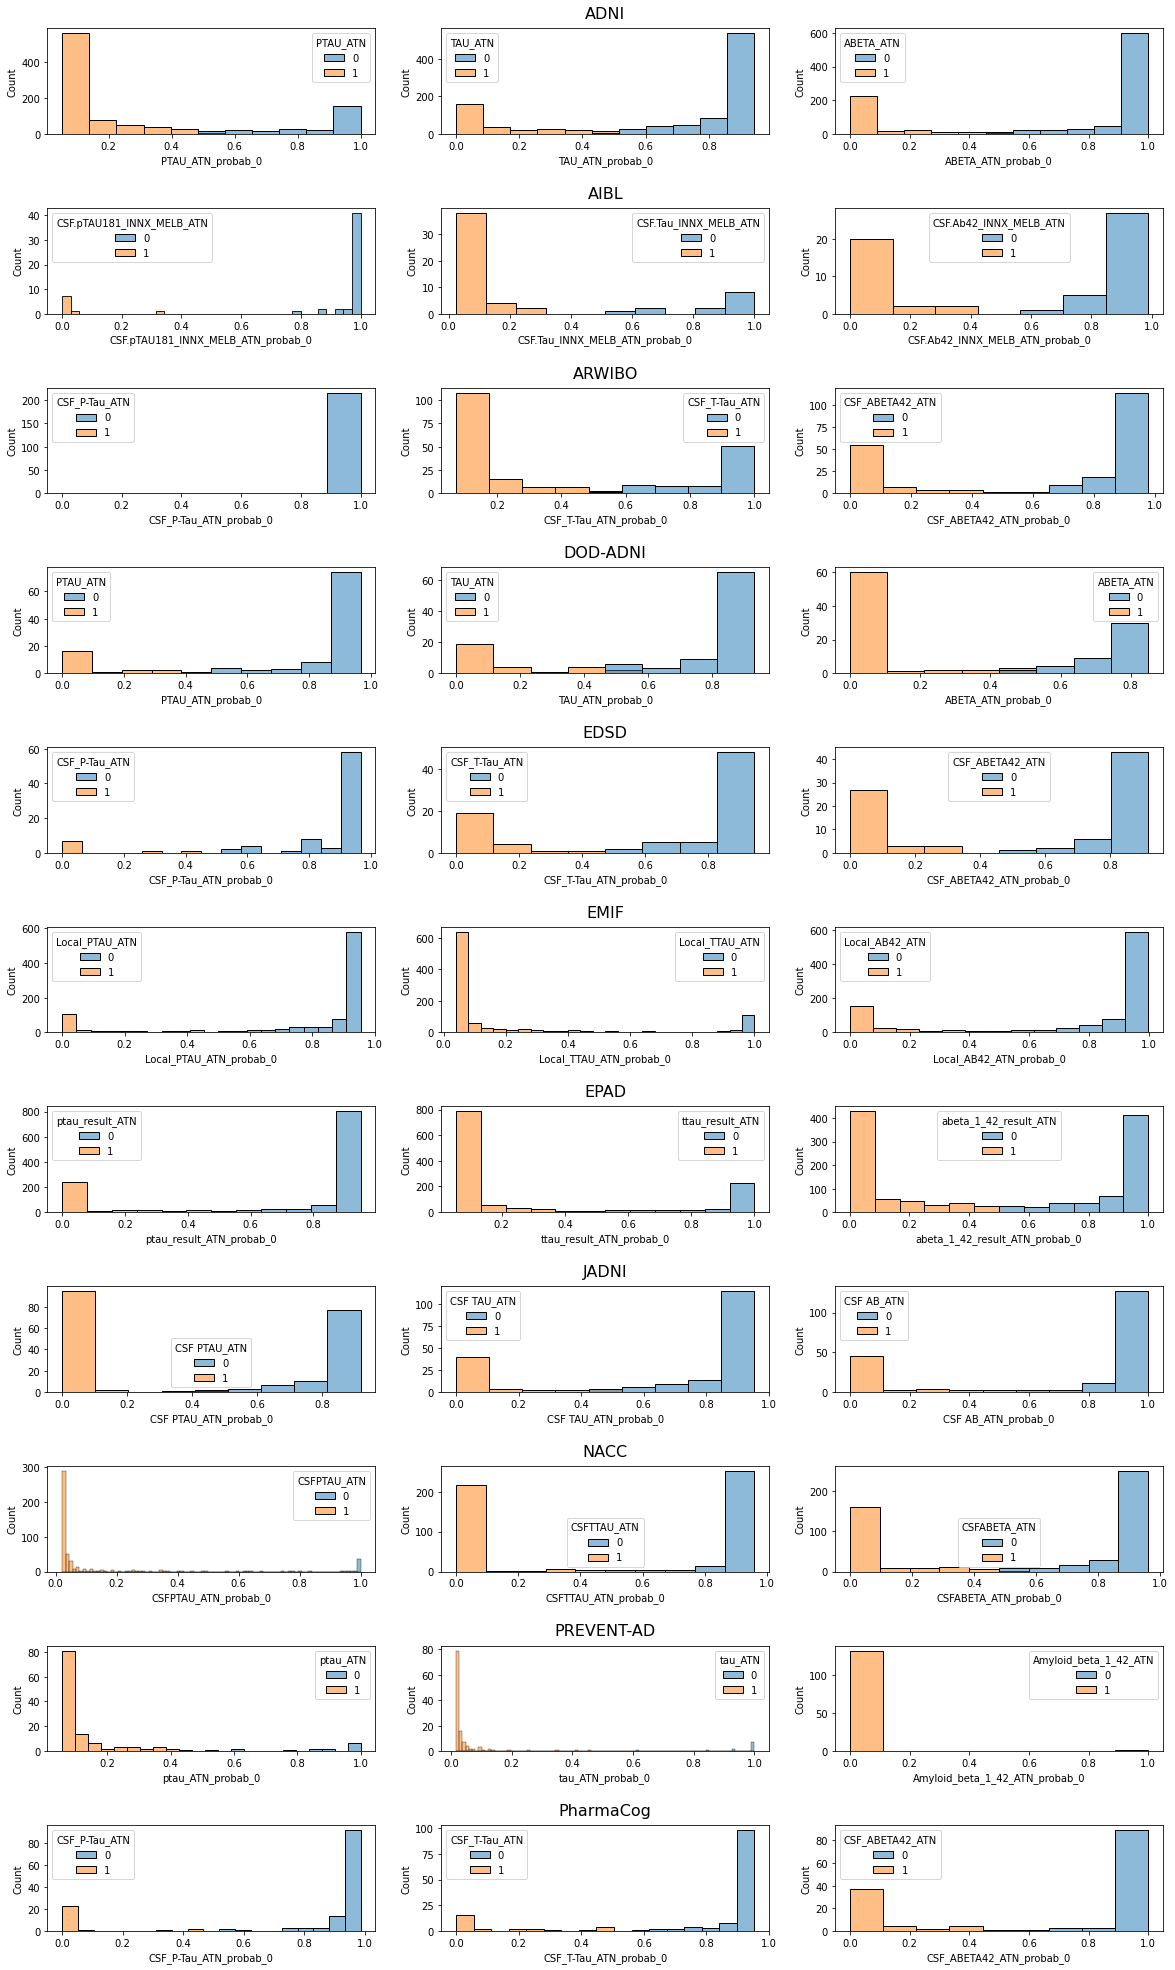

In [42]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:

    csf = mappings['csf'].iloc[:3][ind].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    colors = {0:'#2671bd', 1: '#87a8c9'}
    
    for bioma in csf:
#         sns.scatterplot(y=cohorts_csf[ind][bioma + '_ATN_probab_0'], x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
#         sns.scatterplot(y=cohorts_csf[ind][bioma + '_ATN_probab_1'], x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], color='r')

        sns.histplot(x=round(cohorts_csf[ind][bioma + '_ATN_probab_0'], 3), ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], color=colors)
#         sns.histplot(round(cohorts_csf[ind][bioma + '_ATN_probab_1'], 3), ax=axes[i, csf.index(bioma)], color='b')

        
#         axes[i, csf.index(bioma)].set_title(bioma.upper())
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
        
    i+=1
    
# plt.savefig("csf_biomarkers_cluster.png", dpi=300)

### plot all clusters for each biomarker in each cohort

In [43]:
def solve(m1, m2, std1, std2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
    return np.roots([a,b,c])

/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ysalimi/.local/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


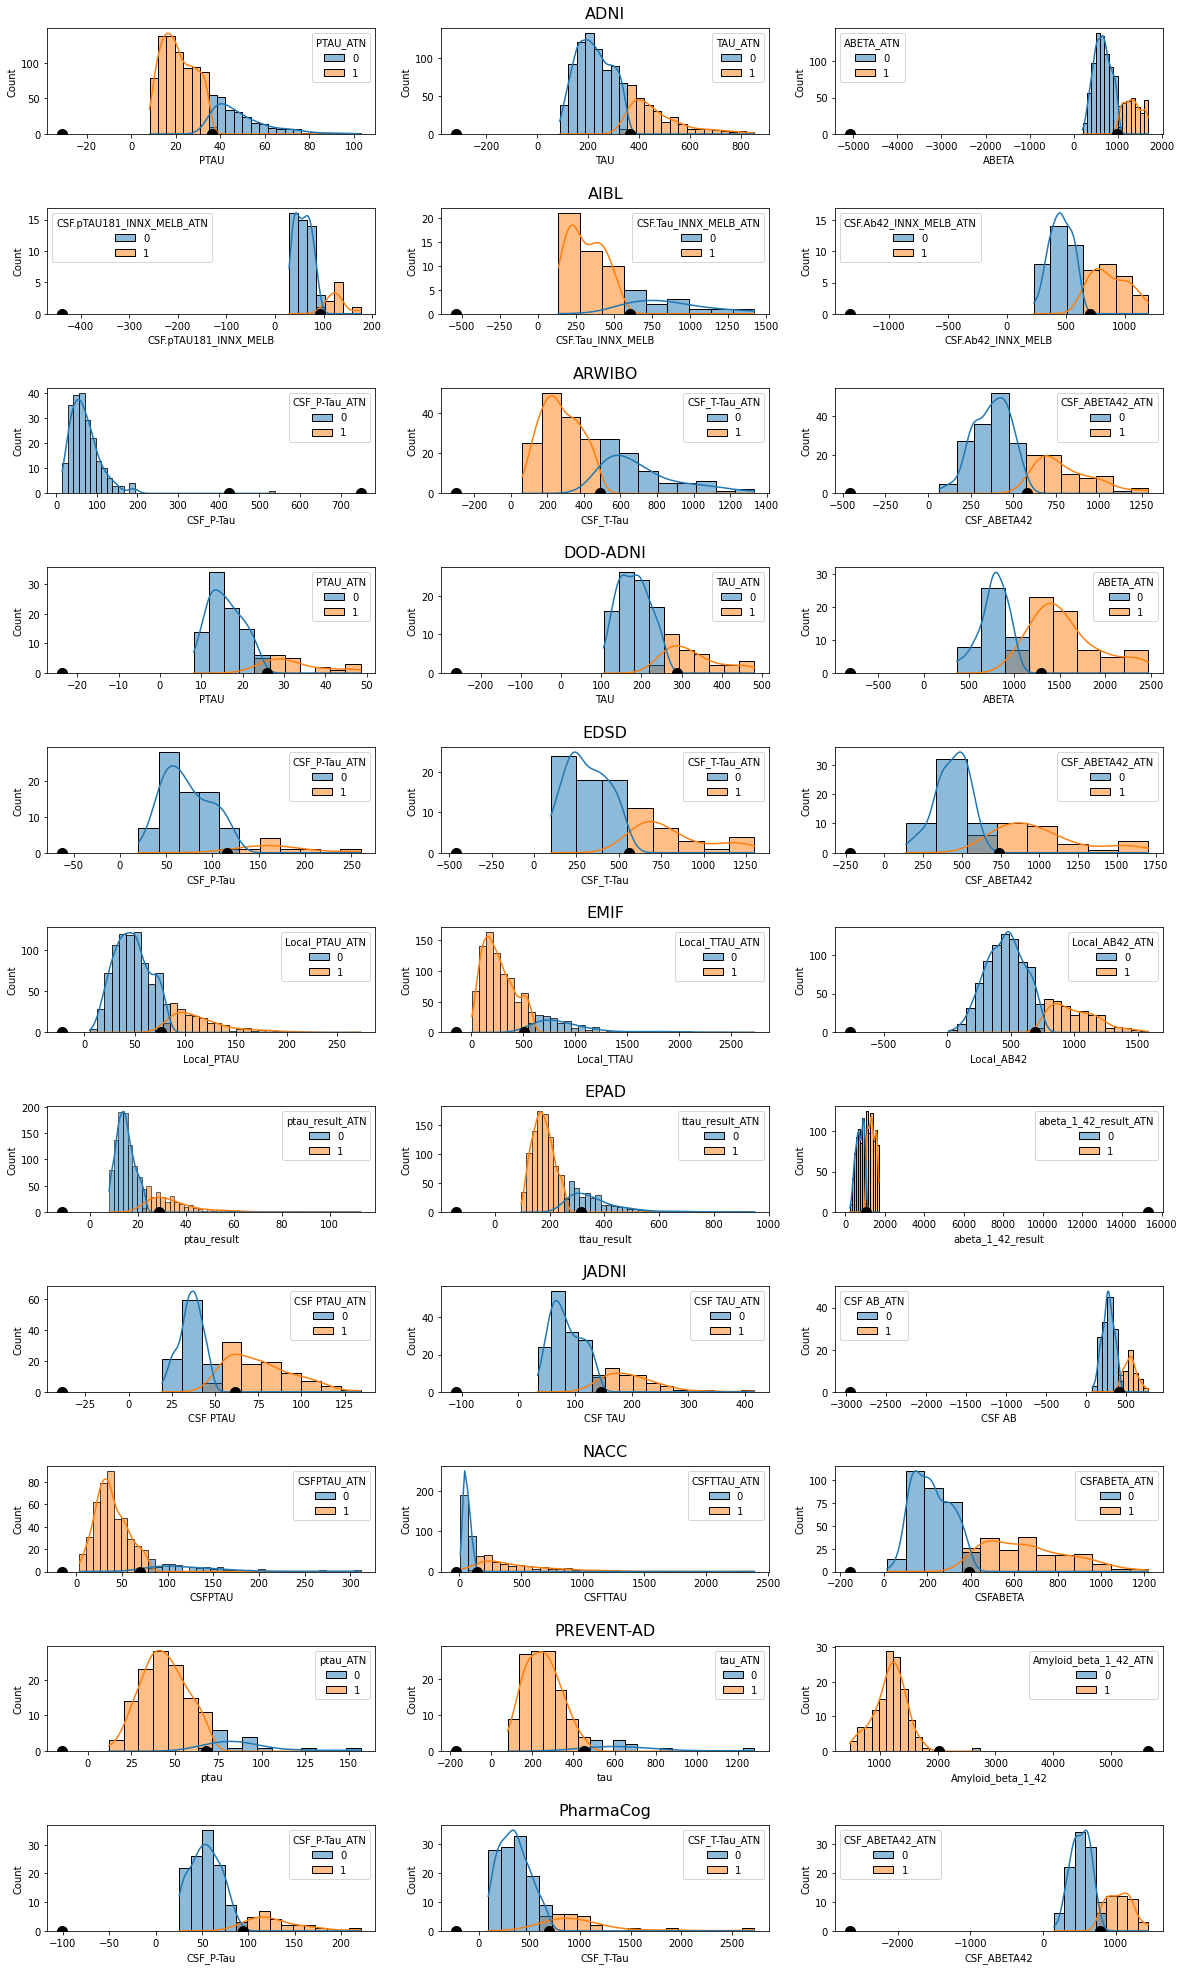

In [44]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
    csf = mappings['csf'].iloc[:3][ind].to_list()
    csf_harmon = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, bioma_har in zip(csf, csf_harmon):
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"], kde=True)
        m11, std11 = mean_sd_df.loc[ind][['mean1_'+ bioma_har + '_rs', 'var1_'+ bioma_har + '_rs']]
        m22, std22 = mean_sd_df.loc[ind][['mean2_'+ bioma_har + '_rs', 'var2_'+ bioma_har + '_rs']]
        result = solve(m11, m22, std11, std22)
        axes[i, csf.index(bioma)].plot(result, norm.pdf(result,m11,std11),'o', markersize=10, color='black')
        axes[i, 1].set_title(ind, fontsize=16, pad=10)
    
    i+=1

In [45]:
cutpointssss_GMM = pd.DataFrame(index=cohorts_csf.keys(), columns=mappings['csf'].iloc[:3]['Feature'].to_list())
cutpointssss = pd.DataFrame(index=cohorts_csf.keys(), columns=mappings['csf'].iloc[:3]['Feature'].to_list())

In [46]:
cohorts_csf['ADNI']

,PTAU,TAU,ABETA,Diagnosis,Age,PTAU_scaled,TAU_scaled,ABETA_scaled,Age_scaled,PTAU_ATN,PTAU_ATN_probab_0,PTAU_ATN_probab_1,TAU_ATN,TAU_ATN_probab_0,TAU_ATN_probab_1,ABETA_ATN,ABETA_ATN_probab_0,ABETA_ATN_probab_1
RID,,,,,,,,,,,,,,,,,,
1002,12.57,157.3,1449.0,CU,76.3,0.045996,0.089908,0.834003,0.591892,1,0.052575,0.947425,0,0.943885,0.056115,1,0.000504,0.999496
1009,21.39,201.9,561.3,CU,75.8,0.139044,0.148353,0.239826,0.578378,1,0.072729,0.927271,0,0.933002,0.066998,0,0.997227,0.002773
1010,27.78,305.5,594.9,MCI,74.2,0.206456,0.284114,0.262316,0.535135,1,0.155411,0.844589,0,0.748230,0.251770,0,0.995979,0.004021
1013,10.89,109.7,376.9,CU,77.8,0.028273,0.027532,0.116399,0.632432,1,0.054778,0.945222,0,0.937502,0.062498,0,0.999566,0.000434
1016,24.71,261.3,1044.0,CU,78.3,0.174069,0.226193,0.562918,0.645946,1,0.102883,0.897117,0,0.874051,0.125949,1,0.375099,0.624901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,37.90,409.0,657.6,MCI,73.1,0.313219,0.419743,0.304284,0.505405,0,0.666566,0.333434,1,0.119443,0.880557,0,0.991731,0.008269
97,18.06,216.6,776.6,CU,72.8,0.103914,0.167617,0.383936,0.497297,1,0.057901,0.942099,0,0.924750,0.075250,0,0.964683,0.035317
981,34.13,375.3,1606.0,CU,84.3,0.273447,0.375582,0.939090,0.808108,1,0.414776,0.585224,1,0.305088,0.694912,1,0.000021,0.999979


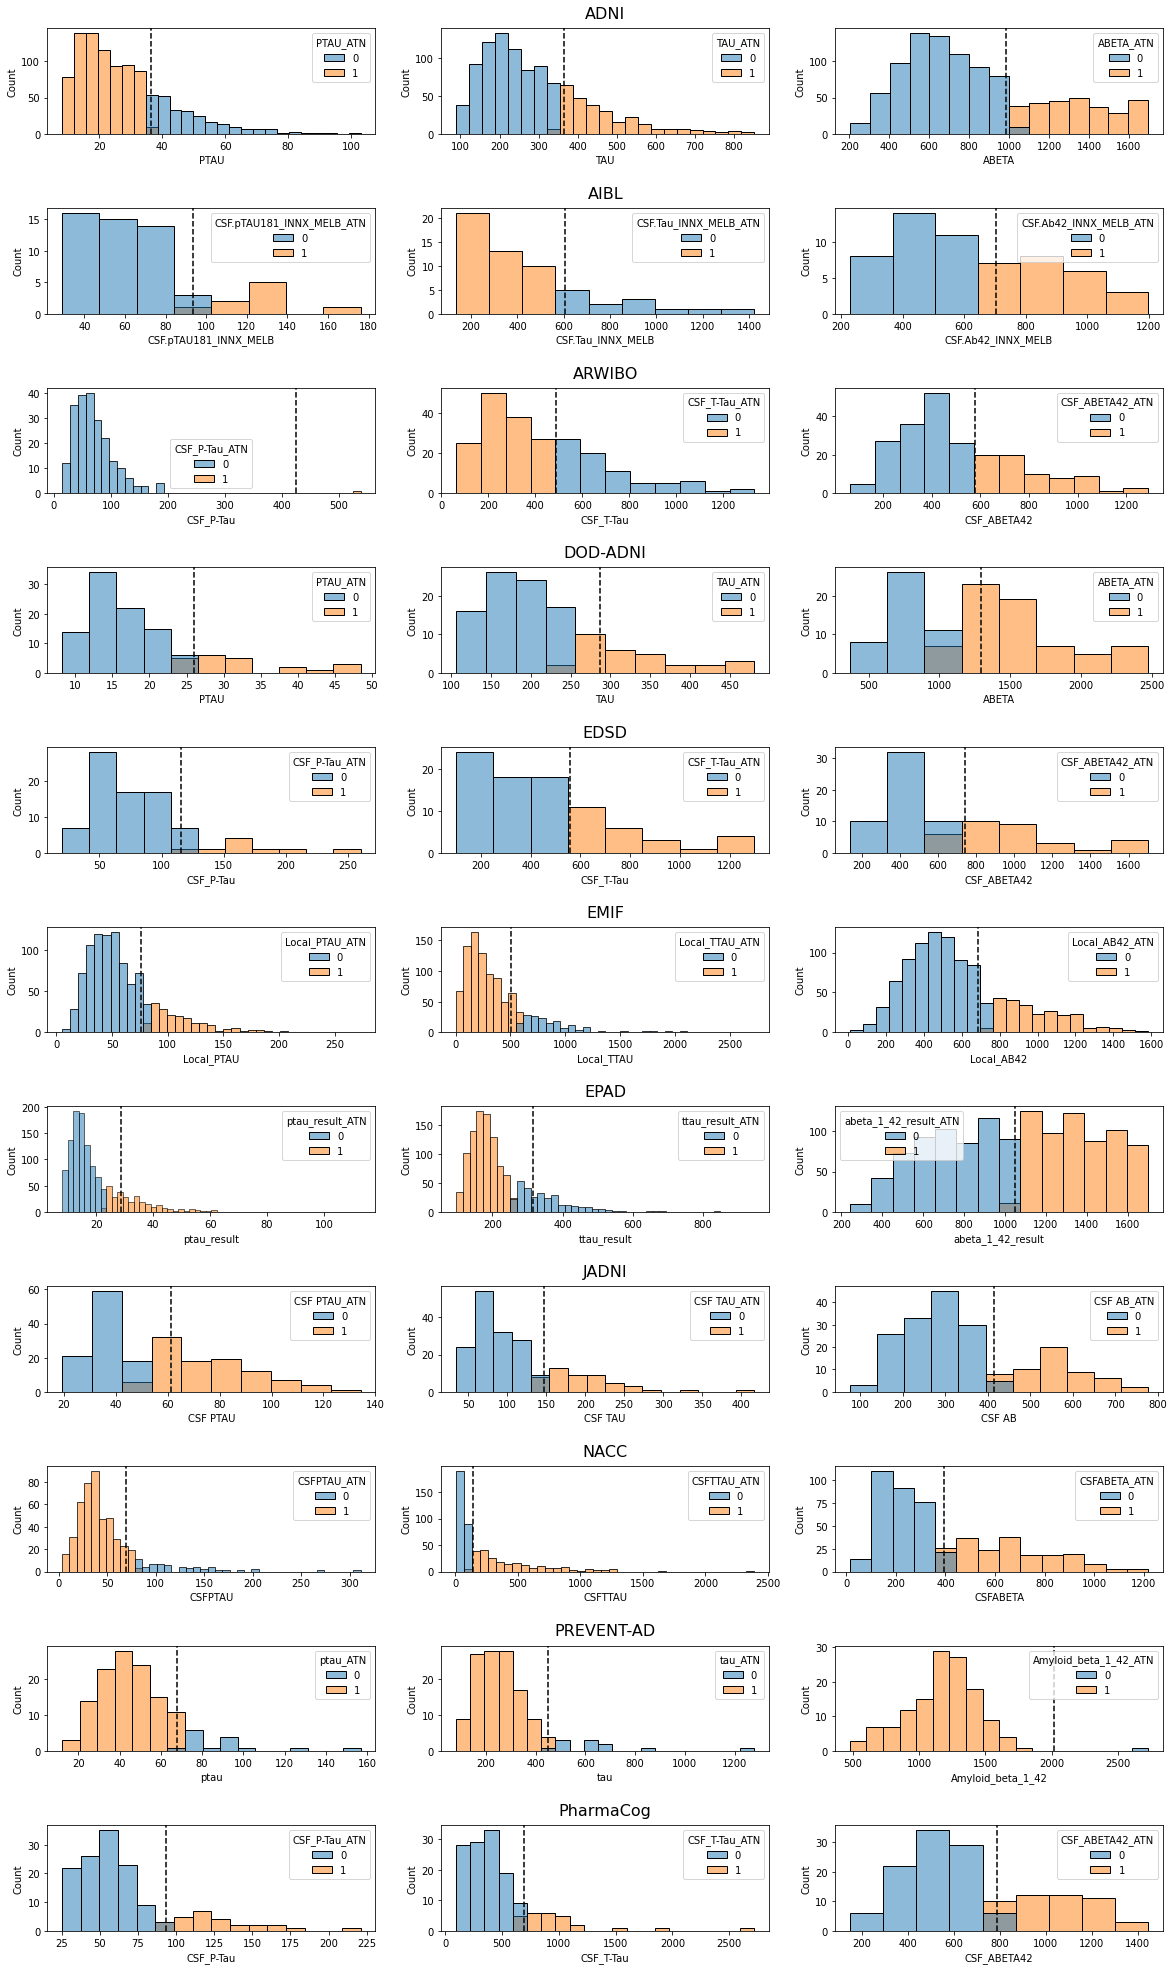

In [47]:
fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
fig.subplots_adjust(hspace=0.7)
i=0

for ind in cohorts_csf:
# for ind in set(cohorts_csf.keys()).difference(['ARWIBO']):
    csf = mappings['csf'].iloc[:3][ind].to_list()
    csf_harmon = mappings['csf'].iloc[:3]['Feature'].to_list()
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    for bioma, bioma_har in zip(csf, csf_harmon):

        m11, std11 = mean_sd_df.loc[ind][['mean1_'+ bioma_har + '_rs', 'var1_'+ bioma_har + '_rs']]
        m22, std22 = mean_sd_df.loc[ind][['mean2_'+ bioma_har + '_rs', 'var2_'+ bioma_har + '_rs']]
        result = solve(m11, m22, std11, std22)
        cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature']] = round(result[np.argmax(norm.pdf(result, m11, std11))], 2)
        axes[i, csf.index(bioma)].axvline(x=cutpointssss_GMM.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 

        # Plot the histogram.
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], density=True, alpha=0.6, color='b')
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], density=True, alpha=0.6, color='g')
        sns.histplot(x=cohorts_csf[ind][bioma], ax=axes[i, csf.index(bioma)], hue=cohorts_csf[ind][bioma + "_ATN"])
#         axes[i, csf.index(bioma)].set_xlabel(bioma, fontsize=12)
#         # Plot the PDF.
#         xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
# #         xmin, xmax = plt.xlim()
#         x = np.linspace(xmin, xmax, 100)
#         p = norm.pdf(x, m11, std11)
#         p2 = norm.pdf(x, m22, std22)

#         axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
#         axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)
        
        axes[i, 1].set_title(ind, fontsize=16, pad=10)

    i+=1

In [48]:
### Plotting clusters and fitting gaussian to each cluster to extract the cutoff values

# fig, axes = plt.subplots(11, 3, sharex=False, figsize=(20, 35))
# fig.subplots_adjust(hspace=0.7)
# i=0

# for ind in cohorts_csf:
#     csf = mappings['csf'].iloc[:3][ind].to_list()
# #     colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
#     for bioma in csf:

#         m11, std11 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma])
#         m22, std22 = norm.fit(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma])
#         result = solve(m11, m22, std11, std22)
#         cutpointssss.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature']] = round(result[np.argmax(norm.pdf(result, m11, std11))], 2)
#         axes[i, csf.index(bioma)].axvline(x=cutpointssss.loc[ind, mappings['csf'].loc[mappings['csf'][ind]==bioma, 'Feature'].item()], c='black', ls='--') 
# #        
#         # Plot the histogram.
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==0, bioma], alpha=0.6, color='r')
#         axes[i, csf.index(bioma)].hist(cohorts_csf[ind].loc[cohorts_csf[ind][bioma + '_ATN']==1, bioma], alpha=0.6, color='y')
#         axes[i, csf.index(bioma)].set_xlabel(bioma, fontsize=12)
#         # Plot the PDF.
#         xmin, xmax = np.min(cohorts_csf[ind][bioma]), np.max(cohorts_csf[ind][bioma])
# #         xmin, xmax = plt.xlim()
#         x = np.linspace(xmin, xmax, 100)
#         p = norm.pdf(x, m11, std11)
#         p2 = norm.pdf(x, m22, std22)

#         axes[i, csf.index(bioma)].plot(x, p, 'k', linewidth=2)
#         axes[i, csf.index(bioma)].plot(x, p2, 'k', linewidth=2)
        
#         axes[i, 1].set_title(ind, fontsize=16, pad=10)

#     i+=1

In [49]:
# Rearrange the columns to A T N 
cutpointssss_GMM = cutpointssss_GMM[['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF']]
# cutpointssss = cutpointssss[['A-beta 1-42 in CSF', 'pTau in CSF', 'tTau in CSF']]

In [50]:
cutpointssss_GMM

,A-beta 1-42 in CSF,pTau in CSF,tTau in CSF
ADNI,986.73,36.5,363.73
AIBL,704.22,93.3,603.97
ARWIBO,577.92,425.48,488.18
DOD-ADNI,1290.68,26.01,287.51
EDSD,741.77,115.35,557.87
EMIF,688.55,75.81,502.71
EPAD,1046.27,28.6,314.42
JADNI,415.19,61.4,146.69
NACC,393.28,69.89,139.45
PREVENT-AD,2019.85,67.97,451.13


In [51]:
cutpointssss_GMM.to_csv("../results/cutoffs/gmm_baseline_cutoffs.csv")

## ATN Profiles

In [52]:
bio_ = list()
for a in ['A', 'T', 'N']: 
    for b in ['+', '-']:
        bio_.append(a+b)
        
profiles_df = pd.DataFrame(index=cutpointssss_GMM.index, columns=bio_)

classes = {i: pd.DataFrame(index=cohorts_csf[i].index, columns=['A', 'T', 'N']) for i in cutpointssss_GMM.index}
for i in classes: classes[i].replace({np.nan: 0}, inplace=True)

In [53]:
for ind in cutpointssss_GMM.index:
    
    for col, letter in zip(cutpointssss_GMM.columns, ['A', 'T', 'N']):
        threshold = cutpointssss_GMM.loc[ind][col]
        bio = mappings['csf'].loc[mappings['csf']['Feature']==col, ind].item()

        if letter == 'T': 
            profiles_df.loc[ind, "T" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "T" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "T"] = 1
        elif letter == 'N': 
            profiles_df.loc[ind, "N" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            profiles_df.loc[ind, "N" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index, "N"] = 1
        else: 
            profiles_df.loc[ind, "A" + '+'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index)
            profiles_df.loc[ind, "A" + '-'] = len(cohorts_csf[ind].loc[cohorts_csf[ind][bio]>threshold].index)
            classes[ind].loc[cohorts_csf[ind].loc[cohorts_csf[ind][bio]<threshold].index, "A"] = 1

In [54]:
profiles_df

,A+,A-,T+,T-,N+,N-
ADNI,708,309,245,772,249,768
AIBL,37,20,9,48,12,45
ARWIBO,146,71,1,216,76,141
DOD-ADNI,63,50,17,96,19,94
EDSD,58,27,15,70,25,60
EMIF,729,285,242,772,258,756
EPAD,600,637,201,1036,195,1042
JADNI,140,57,71,126,45,152
NACC,309,197,85,421,218,288
PREVENT-AD,132,1,17,116,13,120


In [55]:
for i in classes:
    classes[i]['ATN'] = classes[i]['A'].astype(str) + classes[i]['T'].astype(str) + classes[i]['N'].astype(str)

In [56]:
final_profiles = pd.DataFrame(index=classes, columns=list(Counter(classes['ADNI']['ATN']).keys()))
final_profiles.replace({np.nan: 0}, inplace=True)

In [57]:
for i in classes:
    profs = dict(Counter(classes[i]['ATN']))

    for pro in profs:
        final_profiles.loc[i, pro] = profs[pro]

In [58]:
final_profiles.rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)

In [59]:
final_profiles = final_profiles[['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]

In [60]:
final_profiles.to_csv("../results/gmm/final_profiles_gmm_baseline.csv")

In [61]:
final_profiles.replace({np.nan:0})

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,279,24,5,1,18,470,18,202
AIBL,18,0,2,0,0,27,1,9
ARWIBO,55,0,15,1,0,85,61,0
DOD-ADNI,39,9,2,0,0,55,0,8
EDSD,21,1,4,1,2,36,9,11
EMIF,247,23,9,6,34,469,47,179
EPAD,583,43,8,3,14,442,3,141
JADNI,56,0,1,0,29,67,2,42
NACC,57,25,113,2,15,214,37,43
PREVENT-AD,0,1,0,0,5,115,1,11


### Study-Reported Diagnosis of Patients in each ATN Profile 

In [62]:
diag_vs_atn = {i: pd.DataFrame(columns=list(Counter(cohorts_csf['ADNI']['Diagnosis'])) + ['Unknown'], index=list(Counter(classes['ADNI']['ATN']))) for i in cohorts_csf}

In [63]:
# for i in classes:
#     print(i, classes[i]['ATN'].unique())

In [64]:
for coh in classes:
    for i in list(Counter(classes[coh]['ATN'])):
        diag_vs_atn[coh].loc[i] = dict(Counter(cohorts_csf[coh].loc[classes[coh].loc[classes[coh]['ATN']==i].index, 'Diagnosis'].replace({np.nan: 'Unknown'})))

In [65]:
for i in diag_vs_atn: 
    diag_vs_atn[i] = diag_vs_atn[i].transpose()
    diag_vs_atn[i].rename(columns={'000': "A-T-N-", '100': 'A+T-N-', '111': 'A+T+N+', '110': 'A+T+N-', 
                               '011': "A-T+N+", '101': "A+T-N+", '001': 'A-T-N+', '010': 'A-T+N-'}, inplace=True)
    diag_vs_atn[i].replace({np.nan: 98989898}, inplace=True)
    diag_vs_atn[i] = diag_vs_atn[i].astype(int)
    diag_vs_atn[i].replace({98989898: '-'}, inplace=True)

In [66]:
for i in diag_vs_atn:
    diag_vs_atn[i] = diag_vs_atn[i][['A-T-N-', 'A-T+N+', 'A-T-N+', 'A-T+N-', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']]
    diag_vs_atn[i].to_csv("../results/gmm_baseline/diag_atn_gmm_baseline_" + f"{i}" + ".csv")

In [78]:
diag_vs_atn['PharmaCog']

,A-T-N-,A-T+N+,A-T-N+,A-T+N-,A+T+N-,A+T-N-,A+T-N+,A+T+N+
CU,-,-,-,-,-,-,-,-
MCI,45,1,2,-,2,71,3,21
AD,-,-,-,-,-,-,-,-
Unknown,-,-,-,-,-,-,-,-
